In [1]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split, prepare_vectors, quaternion_to_6d_batch, mean_abs_err
from utils import save_parameters_to_csv

torch.manual_seed(42)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Two body: prolate

In [2]:
times = ['11:28_379', '11:26_882', '10:30_343', '09:40_145']

xs,ys = [],[]
for t in times:
    x = np.load(f"../data/X_oblateSpheroid_{t}.npy")
    y = np.load(f"../data/Y_oblateSpheroid_{t}.npy")

    xs.append(x)
    ys.append(y)
    print(t, len(x))

X = np.concatenate(xs, axis=0)
Y = np.concatenate(ys, axis=0)

XY = np.hstack([X, Y])          # shape: (total_rows, 16)

column_names = [
    # X columns (10)
    "center_x", "center_y", "center_z", "dist", "min_dist",
    "quat_x", "quat_y", "quat_z", "quat_w",
    "force_x", "force_y", "force_z",
    "torque_x", "torque_y", "torque_z",
    # Y columns (6)
    "vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"
]

df = pd.DataFrame(XY, columns=column_names)
# df['a'] = 1.0
# df['b'] = 1.0
# df['c'] = 3.0
df.shape

11:28_379 8000
11:26_882 8000
10:30_343 4000
09:40_145 2000


(22000, 21)

In [3]:
#df = pd.read_csv(f"../data/sphere_2body_28k.csv").drop(columns=['Unnamed: 0'])

df = df[df["min_dist"]<8]
df.shape, df.columns

((21151, 21),
 Index(['center_x', 'center_y', 'center_z', 'dist', 'min_dist', 'quat_x',
        'quat_y', 'quat_z', 'quat_w', 'force_x', 'force_y', 'force_z',
        'torque_x', 'torque_y', 'torque_z', 'vel_x', 'vel_y', 'vel_z',
        'angvel_x', 'angvel_y', 'angvel_z'],
       dtype='object'))

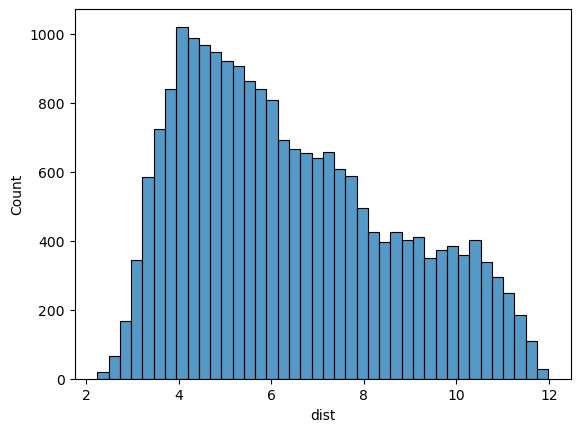

In [4]:
sns.histplot(df["dist"], bins=40);

In [5]:
# CVPR: On the continuity of rotation representations in neural networks'19
quaternions = df[['quat_x', 'quat_y', 'quat_z', 'quat_w']].values

# Convert to 6D using the function defined
quaternion_6d = quaternion_to_6d_batch(quaternions)

# New 6D column names
quaternion_6d_columns = ['quat_6d_1', 'quat_6d_2', 'quat_6d_3', 'quat_6d_4', 'quat_6d_5', 'quat_6d_6']

# Replace the original quaternion columns in df with the new 6D representations
df = df.drop(['quat_x', 'quat_y', 'quat_z', 'quat_w'], axis=1)
for i, col in enumerate(quaternion_6d_columns):
    df[col] = quaternion_6d[:, i]

In [6]:
def prepare_vectors(df):
    force_cols = ['force_x', 'force_y', 'force_z', 
                  "torque_x", "torque_y", "torque_z",]
    output_cols = ['vel_x', 'vel_y', 'vel_z', 'angvel_x', 'angvel_y', 'angvel_z']
    feature_cols = [col for col in df.columns if col not in (force_cols + output_cols)]
    print(feature_cols)
    
    dist_vec = df[feature_cols].values
    force_vec = df[force_cols].values
    output_vec = df[output_cols].values
    return dist_vec, force_vec, output_vec

In [7]:
feat, force, vel = prepare_vectors(df)
feat, force, vel = convert_to_tensors(feat, force, vel)

#vel *= 5

tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

['center_x', 'center_y', 'center_z', 'dist', 'min_dist', 'quat_6d_1', 'quat_6d_2', 'quat_6d_3', 'quat_6d_4', 'quat_6d_5', 'quat_6d_6']


(torch.Size([16920, 11]), torch.Size([16920, 6]), torch.Size([4231, 11]))

In [8]:
def L1(d):
    """ Computes the outer product of each 3D vector in the batch with itself. """
    # d: [batch_size, 3]
    return torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]

def L2(d):
    """ Returns the matrix (I - outer(d, d)) for each vector in the batch. """
    # Identity tensor expanded to batch size
    batch_size = d.shape[0]
    I = torch.eye(3).unsqueeze(0).repeat(batch_size, 1, 1).to(device)  # [batch_size, 3, 3]
    ddT = torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]
    return I - ddT

# Predefine the Levi-Civita tensor
levi_civita = torch.zeros(3, 3, 3, dtype=torch.float)
levi_civita[0, 1, 2] = 1
levi_civita[1, 2, 0] = 1
levi_civita[2, 0, 1] = 1
levi_civita[0, 2, 1] = -1
levi_civita[2, 1, 0] = -1
levi_civita[1, 0, 2] = -1

levi_civita = levi_civita.to(device)

def L3(d):
    """ Computes the cross product matrix for each 3D vector in the batch. """
    # Using einsum for batched matrix-vector multiplication:
    return torch.einsum('ijk,bk->bij', levi_civita, d)  # [batch_size, 3, 3]

def spsd_loss_func(sym_matrix, epsilon=1e-6):
    """SPSD loss representing SPSD violation
    """
    eigenvalues = torch.linalg.eigvalsh(sym_matrix)  # (batch_size, 6)
    negative_violations = torch.relu(-eigenvalues + epsilon)  # (batch_size, 6)
    loss = torch.mean(negative_violations)
    
    return loss

In [9]:
viscosity = 1.0
eigens = []

class ScNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ScNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 5),
            #nn.Tanh()
        )
        
    def forward(self, r, print_scalars=False):
        x = self.layers(r)
        return x

    def predict_mobility(self, X, print_scalars=False):
        d_vec, r = X[:,:3], X[:,3]
        sc = self.forward(X, print_scalars)

        d_vec = -d_vec/ r.unsqueeze(-1) # negative,cz dvec=target-src
        TT = sc[:, 0].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 1].unsqueeze(1).unsqueeze(2) * L2(d_vec) # TODO: d_vec or r?
        RT = sc[:, 2].unsqueeze(1).unsqueeze(2) * L3(d_vec)
        RR = sc[:, 3].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 4].unsqueeze(1).unsqueeze(2) * L2(d_vec)
    
        K = torch.zeros((len(X), 6, 6), dtype=torch.float32, device=X.device)

        # After experiments, the kernel is NOT symmetric. 
        # Top-right and bottem left should NOT be transpose of each other
        K[:, :3, :3] = TT  # Top-left block
        K[:, 3:, :3] = RT  # Bottom-left block
        K[:, :3, 3:] = RT  # Top-right block (transpose of B)
        K[:, 3:, 3:] = RR  # Bottom-right block

        nonSPD = 0
        nonSym = 0
        global eigens
        if not self.training:
            print("Activating SPSD check..")
            for i in range(len(K)):
                k66 = K[i].detach().cpu()
                eigs = np.linalg.eigvals(k66)
                if not np.all(eigs>=- 1e-4):
                    eigens.append((eigs.min(), eigs.max()))
                    nonSPD += 1
                if not np.allclose(k66, k66.T, atol=1e-4):
                    nonSym += 1
                    
            print(f"{nonSPD=}, {nonSym=}, {len(K)}")
        return K

    def predict_velocity(self, X, force, return_M=False):
        M = self.predict_mobility(X)/viscosity
        velocity = torch.bmm(M, force.unsqueeze(-1)).squeeze(-1)
        if return_M:
            return velocity, M
        return velocity

class RelativeMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        """        
            loss = ||y_pred - y||^2 / (||y||^2 + eps)
        """
        super(RelativeMSELoss, self).__init__()
        self.eps = eps
        
    def forward(self, predictions, targets):
        # Compute the squared error between predictions and targets.
        squared_error = (predictions - targets) ** 2
        
        # Sum the squared errors over all elements.
        mse = torch.sum(squared_error)
        
        # Compute the squared L2 norm of the targets (i.e., sum(target**2)).
        norm_squared = torch.sum(targets ** 2)
        
        # Compute the relative MSE by dividing the error by the norm (with eps for safety).
        relative_mse = mse / (norm_squared + self.eps)
        return relative_mse


## Modelling

In [10]:
input_dim = train_dist_tensor.shape[1]
batch_size = 256
epochs = 350
model = ScNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.L1Loss()
#criterion = nn.MSELoss()
#criterion = RelativeMSELoss()
n_iter = train_velocity_tensor.shape[0]//batch_size
n_iter, n_iter*batch_size, len(train_dist_tensor)

(66, 16896, 16920)

In [14]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)
    
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, train_velocity_tensor = shuffle_tensors(
        train_dist_tensor, train_force_tensor, train_velocity_tensor
    )
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force = train_force_tensor[indices] 
        Y = train_velocity_tensor[indices]  
    
        batch_output, M = model.predict_velocity(X, force, return_M=True)

        # Compute loss
        data_loss = criterion(batch_output, Y)
        spsd_loss = 0.1 * spsd_loss_func(M)
        loss = data_loss + spsd_loss
        
        loss.backward()
        avg += loss.item()
        avg_data += data_loss.item()
        avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)
        data_losses.append(avg_data/n_iter)
        spsd_losses.append(avg_spsd/n_iter)

torch.save(model.state_dict(), "oblate_2body.wt")

Epoch 0, Loss: 0.007937141644740195
Epoch 5, Loss: 0.005726472615744128
Epoch 10, Loss: 0.006673535783634041
Epoch 15, Loss: 0.005948275334737969
Epoch 20, Loss: 0.005633374563220776
Epoch 25, Loss: 0.005536144775705356
Epoch 30, Loss: 0.006096975433386185
Epoch 35, Loss: 0.004606575281782584
Epoch 40, Loss: 0.004590529207648201
Epoch 45, Loss: 0.005169986761316206
Epoch 50, Loss: 0.005543769866397435
Epoch 55, Loss: 0.005500408891362675
Epoch 60, Loss: 0.005586816301343568
Epoch 65, Loss: 0.005347915910974596
Epoch 70, Loss: 0.0044333835372306184
Epoch 75, Loss: 0.004272863321768289
Epoch 80, Loss: 0.004384667665528303
Epoch 85, Loss: 0.004672346940038331
Epoch 90, Loss: 0.004520273887354768
Epoch 95, Loss: 0.004275765372299109
Epoch 100, Loss: 0.00492541707882827
Epoch 105, Loss: 0.004760060501708226
Epoch 110, Loss: 0.0040870461838715
Epoch 115, Loss: 0.004249678261465196
Epoch 120, Loss: 0.003915367630366801
Epoch 125, Loss: 0.003892480939005812
Epoch 130, Loss: 0.00449546883729371

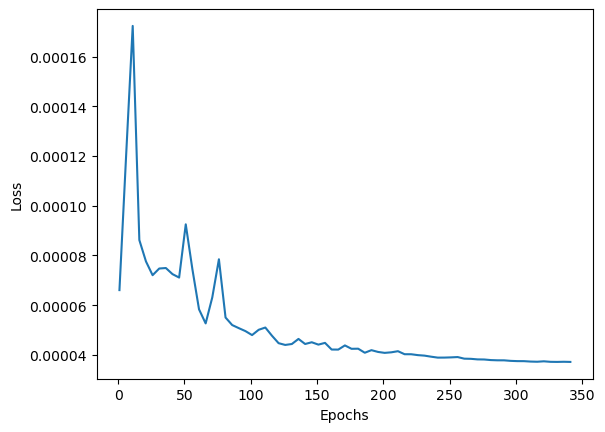

In [12]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.savefig("loss.png");

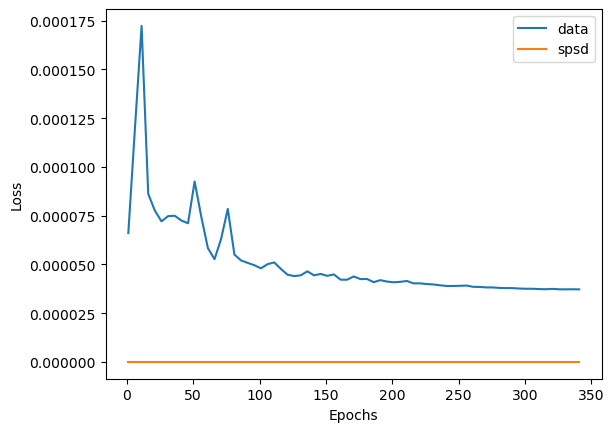

In [13]:
SKIP = 1
los = data_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='data');

los = spsd_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='spsd');

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.savefig("loss.png");

In [14]:
data_losses[:5], data_losses[-5:], spsd_losses[:5], spsd_losses[-5:]

([0.04377138493708623,
  6.608219708366435e-05,
  0.00011984936199294999,
  0.00017230515780837093,
  8.620776715520385e-05],
 [3.7452046282063766e-05,
  3.7245270880131226e-05,
  3.7209601623075776e-05,
  3.726720511697271e-05,
  3.72054000388406e-05],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0])

## Evaluation

In [11]:
model = ScNetwork(input_dim).to(device)
model.load_state_dict(torch.load("oblate_2body.wt", weights_only=True))
model.eval()

eigens = []
with torch.no_grad():
    val_output, M = model.predict_velocity(val_dist_tensor, val_force_tensor, return_M=True)

Activating SPSD check..
nonSPD=30, nonSym=4231, 4231


In [12]:
directory = "/home/shihab/programs/QPGD/data/oblate2body"
save_parameters_to_csv(model, directory)

Parameters saved to /home/shihab/programs/QPGD/data/prolate2body directory.


In [17]:
M[0];

30


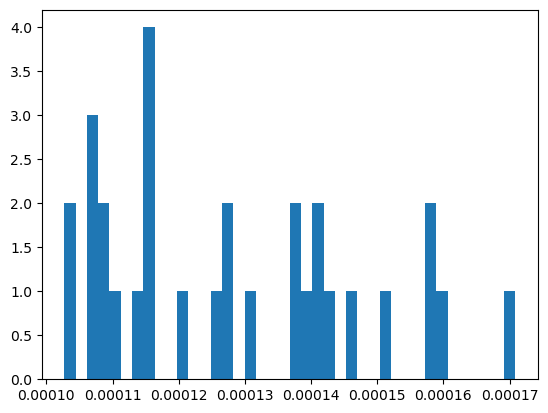

In [18]:
print(len(eigens))
if len(eigens):
    eigens = np.abs(np.array(eigens))
    plt.hist(eigens[:,0], bins=40);

In [19]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 199
val_output[jj], val_velocity_tensor[jj]

(tensor([-0.175092,  0.185300,  0.074217, -0.001131, -0.010340,  0.007004],
        device='cuda:0'),
 tensor([-0.173302,  0.188187,  0.075755,  0.010594, -0.001243,  0.006010],
        device='cuda:0'))

In [20]:
criterion = nn.L1Loss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = err.mean(axis=0)

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([0.003666, 0.003570, 0.004064, 0.004389, 0.004572, 0.001145],
       device='cuda:0')
Actual Magnitude:
  tensor([0.090805, 0.090544, 0.091882, 0.011212, 0.011318, 0.009764],
       device='cuda:0')
RMSE: tensor(0.003568, device='cuda:0')


In [21]:
valid_mask = torch.abs(val_velocity_tensor) > 1e-4

filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)


torch.nanmean(relative_error, dim=0)*100

tensor([ 15.215871,  14.253833,  16.604170, 106.624756, 114.548073,  30.046173],
       device='cuda:0')

In [22]:
a,_ = torch.nanmedian(relative_error, dim=0)
a*100

tensor([ 2.900606,  2.854368,  3.132715, 33.883224, 34.758587,  9.631287],
       device='cuda:0')

In [23]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([ 4.037022,  3.942835,  4.422779, 39.144928, 40.390915, 11.730840],
       device='cuda:0')

In [24]:
idx = val_dist_tensor[:,3]<4.0
mean_abs_err(val_output[idx], val_velocity_tensor[idx])

tensor([ 32.459579,  19.871489,  26.970243, 150.110443, 307.578644,  86.369286],
       device='cuda:0')

In [25]:
idx = val_dist_tensor[:,3]<2.6
mean_abs_err(val_output[idx], val_velocity_tensor[idx])

tensor([  3.093857,   7.174667,   9.849391,  18.643383,  61.210663, 117.961586],
       device='cuda:0')

In [26]:
from scipy import stats
stats.trim_mean(relative_error.cpu().numpy(), .05, axis=0)*100

array([ 5.09099  ,  4.8715644,  5.3305845, 59.668564 , 59.78136  ,
       16.650537 ], dtype=float32)

## Nearfield

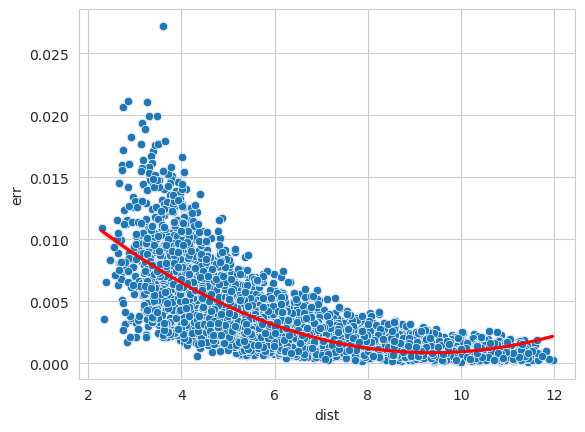

In [27]:
err = (torch.abs(val_output-val_velocity_tensor)).mean(axis=1)

tdf = pd.DataFrame({
    'dist': val_dist_tensor[:,3].cpu().numpy(),
    'err': err.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist', y='err', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist', y='err', data=tdf)
#plt.ylim(0, 100.0);


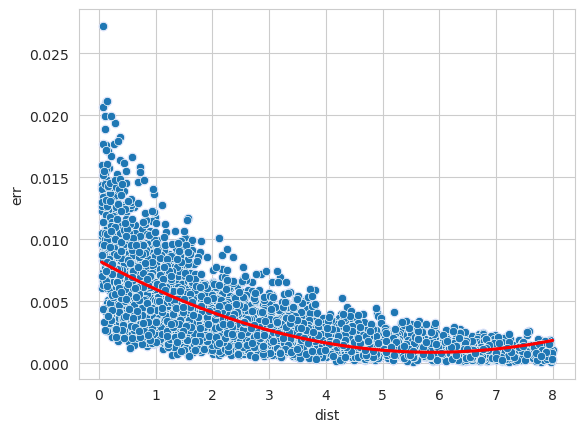

In [28]:
err = (torch.abs(val_output-val_velocity_tensor)).mean(axis=1)

tdf = pd.DataFrame({
    'dist': val_dist_tensor[:,4].cpu().numpy(),
    'err': err.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist', y='err', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist', y='err', data=tdf)
#plt.ylim(0, 100.0);


Below 25%: 0.5235168990782321


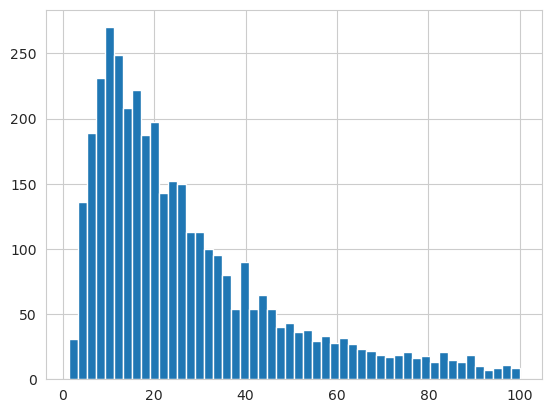

In [31]:
err = (torch.abs((val_output-val_velocity_tensor)/val_velocity_tensor)).mean(axis=1)
ddd = err.detach().cpu().numpy()*100
print("Below 25%:", (ddd<25).sum()/err.shape[0])

ddd = ddd[ddd<100]

plt.hist(ddd, bins=50);

Below 10%: 0.7667218151737178


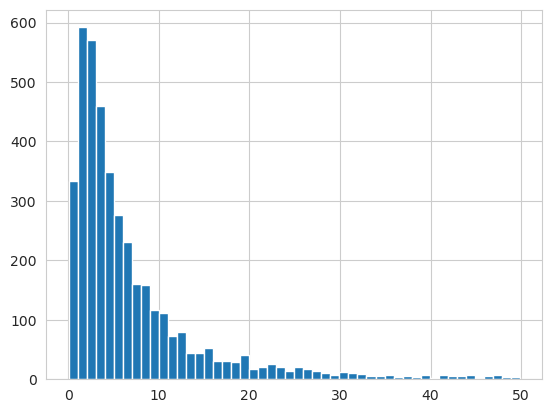

In [32]:
err = (torch.abs((val_output[:,:3]-val_velocity_tensor[:,:3])/val_velocity_tensor[:,:3])).mean(axis=1)
ddd = err.detach().cpu().numpy()*100
print("Below 10%:", (ddd<10).sum()/err.shape[0])

ddd = ddd[ddd<50]

plt.hist(ddd, bins=50);

In [29]:
err.min()

tensor(0.000125, device='cuda:0')

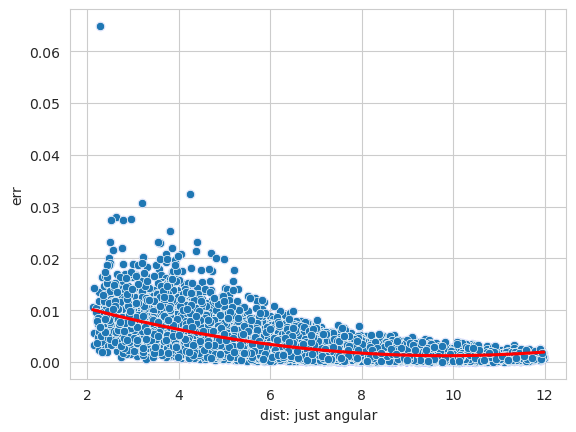

In [30]:
err = torch.abs(val_output[:,3:]-val_velocity_tensor[:,3:]).mean(axis=1)

tdf = pd.DataFrame({
    'dist: just angular': val_dist_tensor[:,3].cpu().numpy(),
    'err': err.detach().cpu().numpy()
})
sns.set_style("whitegrid")
ax = sns.regplot(x='dist: just angular', y='err', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
             line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist: just angular', y='err', data=tdf)

In [31]:
len(tdf)

6268

## RPY

ValueError: Could not interpret value `dist` for `x`. An entry with this name does not appear in `data`.

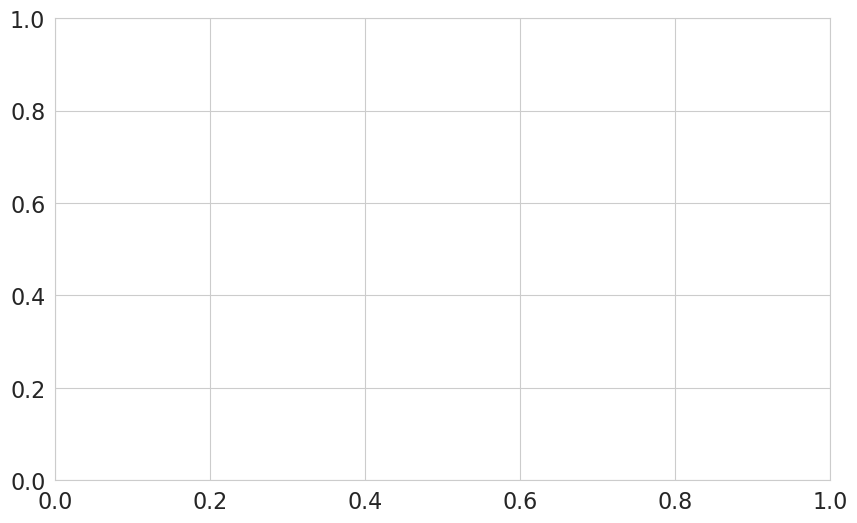

In [32]:
def show_err_plot(tdf):
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 16})  # Adjust the font size as needed

    # Create a figure and a single axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot for NN-based tensor error
    sns.scatterplot(x='dist', y='err', data=tdf, ax=ax,
                    color='blue', alpha=0.15, label='NN-based Tensor')

    # Set axis labels
    ax.set_xlabel("Pair Particle Distance")
    ax.set_ylabel("Error")

    # Create legend
    ax.legend(title='Legend')

    # Save and show the plot
    plt.savefig("rpy_vs_nn.png")
    plt.show()

show_err_plot(tdf)

In [ ]:
Lim = 3.5
show_err_plot(tdf[tdf['dist']<Lim])

In [ ]:
idx = (tdf['dist']>=3.5) & (tdf['dist']<8.0)
show_err_plot(tdf[idx])

In [ ]:
cols = ["vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"]
xdf = df[df['dist']>6.0]
np.abs(xdf[cols]).mean()

In [ ]:
xdf = df[df['dist']<8.0]
np.abs(xdf[cols]).mean()

In [ ]:
t = .416
p = .432

abs(t-p)/t*100

In [ ]:
t = .07824
p = .0897

abs(t-p)/t*100

In [ ]:
t = 0.31859
p = 0.330

abs(t-p)/t*100

In [ ]:
t = 0.06925
p = 0.07312

abs(t-p)/t*100